In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

import lightning as L
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class BasicLightning(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        self.bfinal = nn.Parameter(torch.tensor(0.0), requires_grad=True)
        self.learning_rate = 0.00214

    def forward(self, inp):
        input_to_top_relu = inp * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01

        input_to_bottom_relu = inp * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11

        input_to_final_relu = scaled_bottom_relu_output + scaled_top_relu_output + self.bfinal
        output = F.relu(input_to_final_relu)

        return output
    
    def configure_optimizers(self):
        return SGD(self.parameters(), lr=self.learning_rate)
    
    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = (output_i - label_i) ** 2

        return loss

In [4]:
inputs = torch.tensor([0.0, 0.5, 1.0])
labels = torch.tensor([0.0, 1.0, 0.0])

dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

model = BasicLightning()
trainer = L.Trainer(max_epochs=1000, accelerator="auto", devices="auto")
tuner = L.pytorch.tuner.Tuner(trainer)

lr_find_results = tuner.lr_find(model, train_dataloaders=dataloader, min_lr=0.001, max_lr=0.1, early_stop_threshold=None)

model.learning_rate = lr_find_results.suggestion()
trainer.fit(model, train_dataloaders=dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/dacedev/Documents/hands-on-oreilly/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/dacedev/Documents/hands-on-oreilly/venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr: 100%|██████████| 100/100 [00:00<00:00, 685.66it/s]
Learning rate set to 0.0016595869074375606
Restoring states from the checkpoint path at /home/dacedev/Documents/hands-on-oreilly/.lr_f

Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 135.81it/s, v_num=9]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 97.03it/s, v_num=9] 


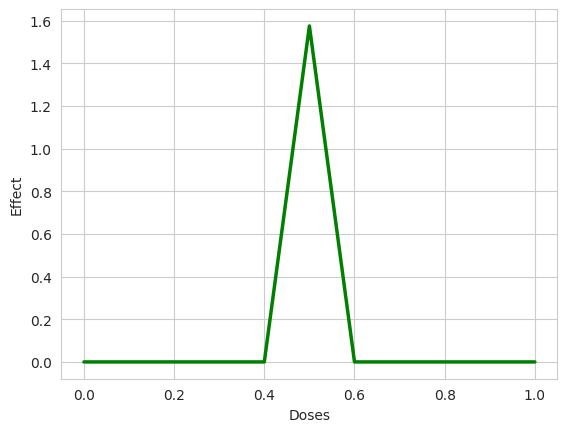

In [5]:
input_doses = torch.linspace(start=0.0, end=1.0, steps=11)
output_values = model(input_doses)

sns.set_style("whitegrid")
sns.lineplot(x=input_doses, y=output_values.detach(), color="green", linewidth=2.5)
plt.xlabel("Doses")
plt.ylabel("Effect")
plt.show()